In [1]:
import sys
import os

sys.path.append("Methods/GroHess/Two layers")
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/Methods/GroHess/Two layers/data"

HPO_name = "greedy_HPO"
method_name = "GroHess_two_layers"
benchmark_name = "pMNIST"

In [2]:
from lib.abstract_torch import get_device
from lib.dataloader import get_task_loaders
from lib.models import ANN
from lib.train import train
from lib.test import test
from HPO_lib.visualize import visualize_accs_matrix, visualize_avg_acc_curve, visualize_best_params, visualize_val_accs_matrix, visualize_accuracy_through_benchmarks, visualize_violin

import numpy as np
import copy
import optuna
from functools import partial

import warnings
warnings.filterwarnings('ignore')

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = get_device(1)

In [4]:
# Must tune hyperparameters
num_tasks = 4
train_percentage = 0.2
difficulty = "standard"
grow_from = "output"
n_trials = 3
num_val_benchmarks = 5

# Set the percentile threshold for building Hessian and gradient masks
hessian_percentile = 95
grad_percentile = 95

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 50
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Other hyperparameters
#num_epochs = 3
#lr = 1e-3

Fixed hyperparameters :
- Start by growing left layer at each new task to handle and then alternate
- Growth trigger :
    - delay_growth (at each new task to handle)
    - delay_growth
    - should_we_grow

# HPO

## Reproducibility

In [5]:
random_seed = 88
permutation_random_seeds = list(range(num_tasks))

## Get p-MNIST loaders

In [6]:
train_loaders_list, val_loaders_list, test_loaders_list = [], [], []
for random_seed in permutation_random_seeds :
    train_loader, val_loader, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=train_percentage, difficulty=difficulty, download=False)
    train_loaders_list += [train_loader]
    val_loaders_list += [val_loader]
    test_loaders_list += [test_loader]

## Perform HPO

In [7]:
def objective(model, task_number, params, device, trial) :

    # Set HPs
    lr = trial.suggest_float("lr", 5e-5, 2e-3)
    num_epochs = trial.suggest_int("num_epochs", 2, 6)

    # Copy the model to perform HPO
    model_copy = copy.deepcopy(model)
    
    # Train
    overall_masks, is_first_task = params
    
    train_loader = train_loaders_list[task_number]

    _ = train(model_copy, grow_from, overall_masks, is_first_task,
                      loss_name, optimizer_name, lr, num_epochs, batch_size,
                      hessian_percentile, grad_percentile,
                      train_loader,
                      device, random_seed, 
                      verbose=0)

    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(model_copy, test_loaders_list[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    score = np.mean(test_accs)
    
    return score

In [8]:
def retrain_and_save_with_best_HPs (model, params, best_params, train_loader) :
    lr = best_params["lr"]
    num_epochs = best_params["num_epochs"]
    
    overall_masks, is_first_task = params

    # Train
    overall_masks, _, _ = train(model, grow_from, overall_masks, is_first_task,
                      loss_name, optimizer_name, lr, num_epochs, batch_size,
                      hessian_percentile, grad_percentile,
                      train_loader,
                      device, random_seed, 
                      verbose=2)
    
    return overall_masks

In [9]:
def call_greedy_HPO(n_trials) :
    # Initialize model
    model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

    # Intialize mask
    if grow_from == "input" :
        overall_masks = [np.ones_like(model.fc1.weight.data.cpu().numpy()),
                        np.ones_like(model.fc2.weight.data.cpu().numpy())]
    else :
        overall_masks = [np.ones_like(model.fc2.weight.data.cpu().numpy()),
                        np.ones_like(model.fc3.weight.data.cpu().numpy())]
            
    # Initialize variable to store the best HPs and the scores
    best_params_list = []
    test_accs_matrix = np.zeros((num_tasks, num_tasks))

    for task_number in range(0,num_tasks) :

        # Verbose
        print("\n" + "-"*50)
        print(f"LEARNING TASK {task_number+1}")

        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name=f"Search number {task_number+1}",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        is_first_task = True if task_number==0 else False
        params = overall_masks, is_first_task
        partial_objective = partial(objective, model, task_number, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials,
                    timeout=3600)

        # Retrain and save a model with the best params
        best_params = study.best_trial.params
        best_params_list += [best_params]
        overall_masks = retrain_and_save_with_best_HPs(model, params, best_params, train_loaders_list[task_number]) 
        
        # Test on each task
        for j in range(num_tasks) :
            test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], batch_size, device),2)
    
    return test_accs_matrix, best_params_list, model

In [10]:
test_accs_matrix, best_params_list, model = call_greedy_HPO(n_trials)

[I 2024-07-04 10:29:34,807] A new study created in memory with name: Search number 1



--------------------------------------------------
LEARNING TASK 1


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]
[I 2024-07-04 10:29:42,602] Trial 0 finished with value: 91.37615384615388 and parameters: {'lr': 0.0011240559100204222, 'num_epochs': 5}. Best is trial 0 with value: 91.37615384615388.
100%|██████████| 4/4 [00:05<00:00,  1.32s/it]
[I 2024-07-04 10:29:48,887] Trial 1 finished with value: 87.09987179487179 and parameters: {'lr': 0.0006172642408802415, 'num_epochs': 4}. Best is trial 0 with value: 91.37615384615388.
100%|██████████| 6/6 [00:07<00:00,  1.32s/it]
[I 2024-07-04 10:29:57,818] Trial 2 finished with value: 92.94846153846153 and parameters: {'lr': 0.0017912465609779267, 'num_epochs': 6}. Best is trial 2 with value: 92.94846153846153.
  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:06,  1.32s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:05,  1.32s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.32s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:05<00:02,  1.32s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:06<00:01,  1.32s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]
[I 2024-07-04 10:30:09,745] A new study created in memory with name: Search number 2



--------------------------------------------------
LEARNING TASK 2


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
[I 2024-07-04 10:30:18,374] Trial 0 finished with value: 91.62621794871797 and parameters: {'lr': 0.0011240559100204222, 'num_epochs': 5}. Best is trial 0 with value: 91.62621794871797.
100%|██████████| 4/4 [00:05<00:00,  1.35s/it]
[I 2024-07-04 10:30:25,789] Trial 1 finished with value: 90.53974358974358 and parameters: {'lr': 0.0006172642408802415, 'num_epochs': 4}. Best is trial 0 with value: 91.62621794871797.
100%|██████████| 6/6 [00:07<00:00,  1.30s/it]
[I 2024-07-04 10:30:35,580] Trial 2 finished with value: 91.68173076923077 and parameters: {'lr': 0.0017912465609779267, 'num_epochs': 6}. Best is trial 2 with value: 91.68173076923077.
  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:06,  1.28s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:05,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:05<00:02,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:06<00:01,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]
[I 2024-07-04 10:30:47,201] A new study created in memory with name: Search number 3



--------------------------------------------------
LEARNING TASK 3


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
[I 2024-07-04 10:30:56,556] Trial 0 finished with value: 87.27264957264958 and parameters: {'lr': 0.0011240559100204222, 'num_epochs': 5}. Best is trial 0 with value: 87.27264957264958.
100%|██████████| 4/4 [00:05<00:00,  1.27s/it]
[I 2024-07-04 10:31:04,637] Trial 1 finished with value: 87.29264957264957 and parameters: {'lr': 0.0006172642408802415, 'num_epochs': 4}. Best is trial 1 with value: 87.29264957264957.
100%|██████████| 6/6 [00:07<00:00,  1.27s/it]
[I 2024-07-04 10:31:15,222] Trial 2 finished with value: 85.72068376068376 and parameters: {'lr': 0.0017912465609779267, 'num_epochs': 6}. Best is trial 1 with value: 87.29264957264957.
  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]
[I 2024-07-04 10:31:24,290] A new study created in memory with name: Search number 4



--------------------------------------------------
LEARNING TASK 4


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
[I 2024-07-04 10:31:34,617] Trial 0 finished with value: 85.53448717948717 and parameters: {'lr': 0.0011240559100204222, 'num_epochs': 5}. Best is trial 0 with value: 85.53448717948717.
100%|██████████| 4/4 [00:05<00:00,  1.27s/it]
[I 2024-07-04 10:31:43,715] Trial 1 finished with value: 86.30282051282053 and parameters: {'lr': 0.0006172642408802415, 'num_epochs': 4}. Best is trial 1 with value: 86.30282051282053.
100%|██████████| 6/6 [00:07<00:00,  1.28s/it]
[I 2024-07-04 10:31:55,394] Trial 2 finished with value: 83.3259294871795 and parameters: {'lr': 0.0017912465609779267, 'num_epochs': 6}. Best is trial 1 with value: 86.30282051282053.
  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.27s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


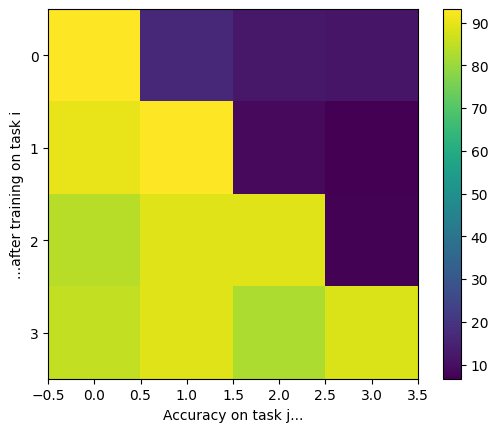

In [11]:
visualize_accs_matrix(test_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

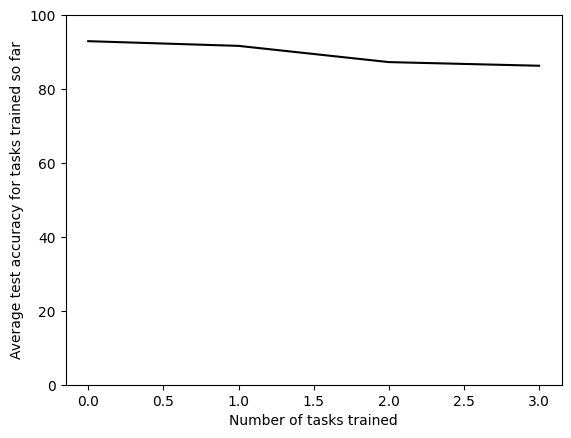

In [12]:
visualize_avg_acc_curve(test_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

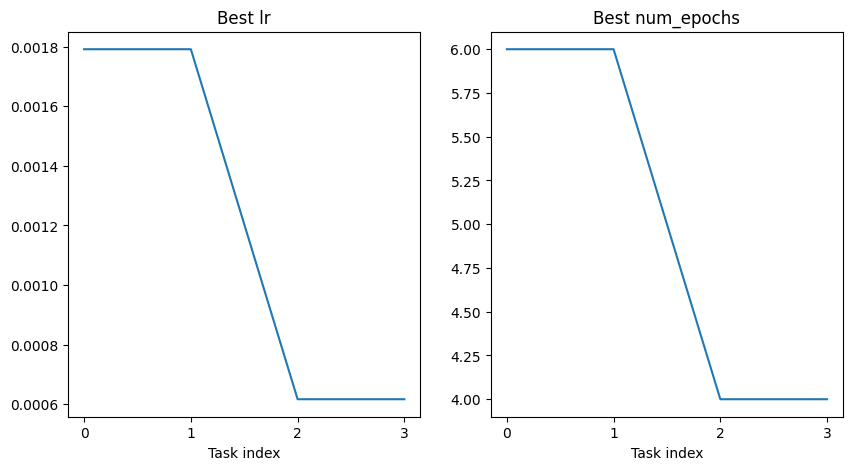

In [13]:
visualize_best_params(best_params_list, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

# Validation benchmarks

## Reproducibility

In [14]:
permutation_random_seeds_list = [list(range(num_tasks*(i), num_tasks*(i+1))) for i in range(0,num_val_benchmarks+1)]

## Get p-MNIST loaders

In [15]:
test_loaders_list_list = []
for i in range(num_val_benchmarks+1) :
    permutation_random_seeds = permutation_random_seeds_list[i]
    test_loaders_list = []
    for random_seed in permutation_random_seeds :
        _, _, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=train_percentage, difficulty="difficult", download=False)
        test_loaders_list += [test_loader]
    test_loaders_list_list += [test_loaders_list]

In [16]:
val_accs_matrix = np.zeros((num_val_benchmarks+2, num_tasks))

In [17]:
def train_with_best_params (best_params_list, test_loaders_list) :
    # Initialize model
    benchmark_model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

    # Intialize mask
    if grow_from == "input" :
        overall_masks = [np.ones_like(benchmark_model.fc1.weight.data.cpu().numpy()),
                        np.ones_like(benchmark_model.fc2.weight.data.cpu().numpy())]
    else :
        overall_masks = [np.ones_like(benchmark_model.fc2.weight.data.cpu().numpy()),
                        np.ones_like(benchmark_model.fc3.weight.data.cpu().numpy())]

    for task_number in range(0,num_tasks) :

        # Verbose
        print("\n" + "-"*50)
        print(f"LEARNING TASK {task_number+1}")

        # Retrain and save a model with the best params
        is_first_task = True if task_number==0 else False
        params = overall_masks, is_first_task
        overall_masks = retrain_and_save_with_best_HPs(benchmark_model, params, best_params_list[task_number], test_loaders_list[task_number]) 
    
    return benchmark_model

In [18]:
for i in range(num_val_benchmarks+2) :
    benchmark_number = 0 if i <= 1 else i-1
    print("\n" + "="*50)
    print(f"BENCHMARK {benchmark_number}")
    # Train model with best params obtained through HPO on benchmark 0
    if i != 0 :
        test_loaders_list = test_loaders_list_list[benchmark_number]
        benchmark_model = train_with_best_params (best_params_list, test_loaders_list)
    else : 
        benchmark_model = copy.deepcopy(model)
    # Test on each task
    for j in range(num_tasks) :
        val_accs_matrix[i,j] = round(test(benchmark_model, test_loaders_list_list[benchmark_number][j], batch_size, device),2)


BENCHMARK 0

BENCHMARK 0

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



BENCHMARK 1

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



BENCHMARK 2

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 68
fc2 : in = 68, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 68
fc2 : in = 68, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 68
fc2 : in = 68, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 68
fc2 : in = 68, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 68
fc2 : in = 68, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



BENCHMARK 3

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



BENCHMARK 4

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 53
fc2 : in = 53, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 53
fc2 : in = 53, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 53
fc2 : in = 53, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 53
fc2 : in = 53, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 53
fc2 : in = 53, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]



BENCHMARK 5

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 3/6 [00:03<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 50%|█████     | 2/4 [00:02<00:02,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


 75%|███████▌  | 3/4 [00:03<00:01,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 50
fc2 : in = 50, out = 50
fc3 : in = 50, out = 10


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


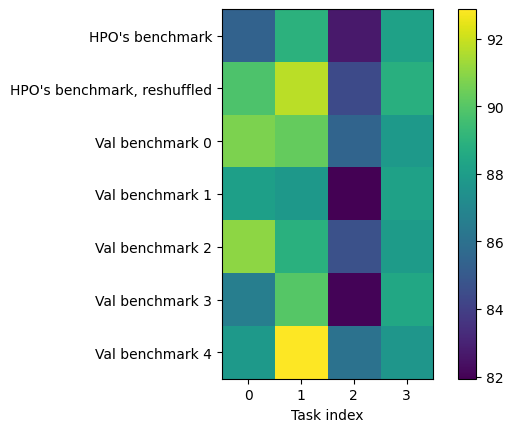

In [19]:
visualize_val_accs_matrix(val_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

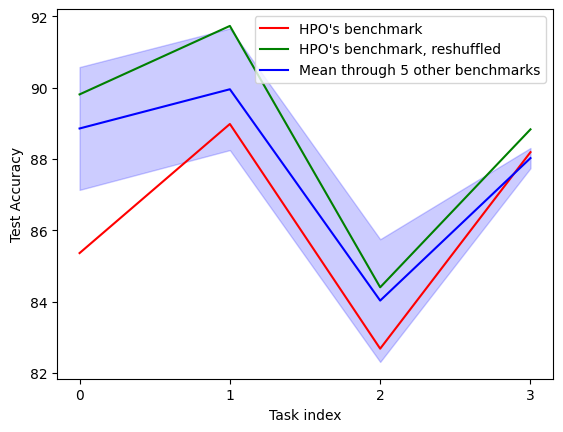

In [20]:
visualize_accuracy_through_benchmarks(val_accs_matrix, HPO_name, num_val_benchmarks, method_name, grow_from, benchmark_name, difficulty, savefig=True)

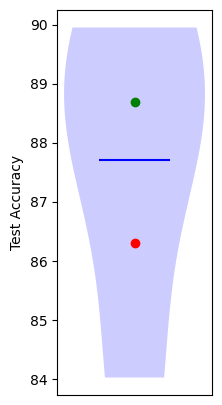

In [21]:
visualize_violin(val_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)